# Time-Resolved Diagnostics for State Space Models

This notebook demonstrates how to apply goodness-of-fit diagnostics to **time series data**, identifying **when and where** models fail. This is the core application of the `statespacecheck` package.

**Learning objectives:**
- Apply diagnostics to realistic time series data
- Identify periods of poor model fit
- Use flagging functions to detect problematic time points
- Aggregate metrics over time periods
- Interpret diagnostic patterns in neuroscience context

**Previous:** [02_highest_density_regions.ipynb](02_highest_density_regions.ipynb) | **Next:** [04_predictive_checks.ipynb](04_predictive_checks.ipynb)

## Setup

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, str(Path.cwd().parent))

from utils import (
    configure_notebook_plotting,
    generate_misspecified_model_data,
    generate_spatial_navigation_data,
)

from statespacecheck import (
    aggregate_over_period,
    combine_flags,
    find_low_overlap_intervals,
    flag_extreme_kl,
    flag_low_overlap,
    hpd_overlap,
    kl_divergence,
)

configure_notebook_plotting()

## Example Scenario: Spatial Navigation

Imagine we have a state space model tracking an animal's position on a linear track. The model uses:
- **State model**: Predicts position based on velocity and past positions
- **Observation model**: Infers position from neural activity (e.g., place cell firing)

We want to know: **Does the model accurately capture the animal's behavior throughout the session?**

## Generate Synthetic Data

Let's create a realistic example where the model works well most of the time but fails during a specific period.

In [2]:
# Generate data with a period of model misfit
data = generate_misspecified_model_data(
    n_time=200, track_length=100.0, n_bins=50, misfit_start=80, misfit_end=120, seed=42
)

position_bins = data["position_bins"]
true_position = data["true_position"]
state_dist = data["state_dist"]
likelihood = data["likelihood"]
time = data["time"]
misfit_start, misfit_end = data["misfit_period"]

# Print data shapes
print("Data shapes:")
print(f"  position_bins: {position_bins.shape}")
print(f"  state_dist: {state_dist.shape}")
print(f"  likelihood: {likelihood.shape}")
print(f"  time: {time.shape}")
print(f"\nMisfit period: time {misfit_start}-{misfit_end}")

Data shapes:
  position_bins: (50,)
  state_dist: (200, 50)
  likelihood: (200, 50)
  time: (200,)

Misfit period: time 80-120


## Visualize Distributions Over Time

Let's first look at the distributions as a heatmap to get a sense of the temporal evolution.

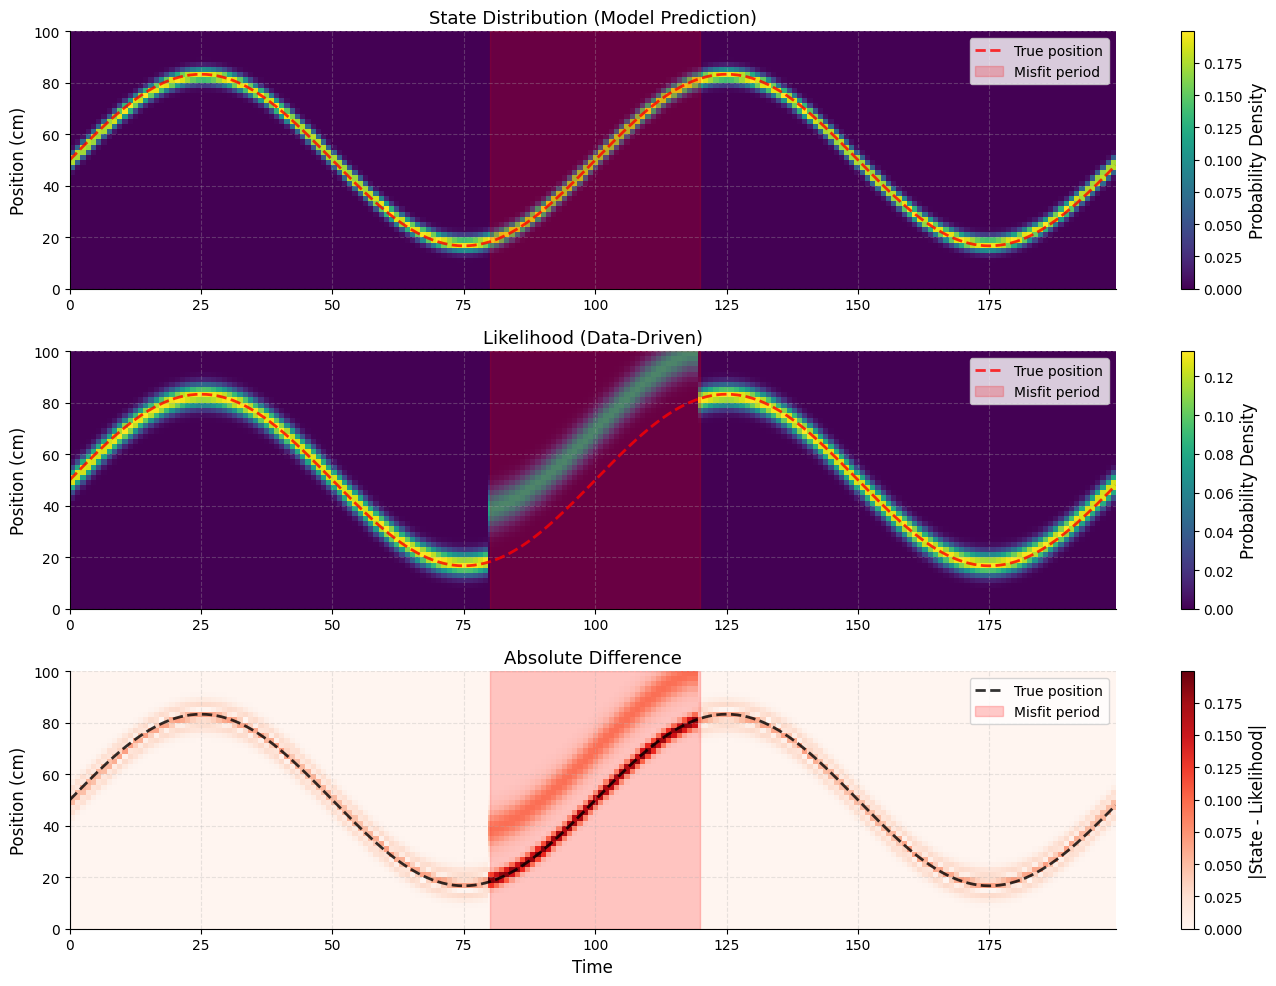

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# State distribution heatmap
im1 = ax1.imshow(
    state_dist.T,
    aspect="auto",
    origin="lower",
    extent=[time[0], time[-1], position_bins[0], position_bins[-1]],
    cmap="viridis",
    interpolation="nearest",
)
ax1.plot(time, true_position, "r--", linewidth=2, label="True position", alpha=0.8)
ax1.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="Misfit period")
ax1.set_ylabel("Position (cm)")
ax1.set_title("State Distribution (Model Prediction)")
ax1.legend(frameon=True, loc="upper right")
plt.colorbar(im1, ax=ax1, label="Probability Density")

# Likelihood heatmap
im2 = ax2.imshow(
    likelihood.T,
    aspect="auto",
    origin="lower",
    extent=[time[0], time[-1], position_bins[0], position_bins[-1]],
    cmap="viridis",
    interpolation="nearest",
)
ax2.plot(time, true_position, "r--", linewidth=2, label="True position", alpha=0.8)
ax2.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="Misfit period")
ax2.set_ylabel("Position (cm)")
ax2.set_title("Likelihood (Data-Driven)")
ax2.legend(frameon=True, loc="upper right")
plt.colorbar(im2, ax=ax2, label="Probability Density")

# Difference (absolute)
diff = np.abs(state_dist - likelihood)
im3 = ax3.imshow(
    diff.T,
    aspect="auto",
    origin="lower",
    extent=[time[0], time[-1], position_bins[0], position_bins[-1]],
    cmap="Reds",
    interpolation="nearest",
)
ax3.plot(time, true_position, "k--", linewidth=2, label="True position", alpha=0.8)
ax3.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="Misfit period")
ax3.set_xlabel("Time")
ax3.set_ylabel("Position (cm)")
ax3.set_title("Absolute Difference")
ax3.legend(frameon=True, loc="upper right")
plt.colorbar(im3, ax=ax3, label="|State - Likelihood|")

plt.tight_layout()
plt.show()

### Observations

- **Top panel**: State distribution tracks the true position smoothly
- **Middle panel**: Likelihood also tracks position, but with a large offset during the misfit period (80-120)
- **Bottom panel**: The difference highlights the misfit period in red

Now let's quantify this disagreement using our diagnostic metrics.

## Compute Time-Resolved Diagnostics

The power of `statespacecheck` is computing diagnostics at **every time point** to identify when models fail.

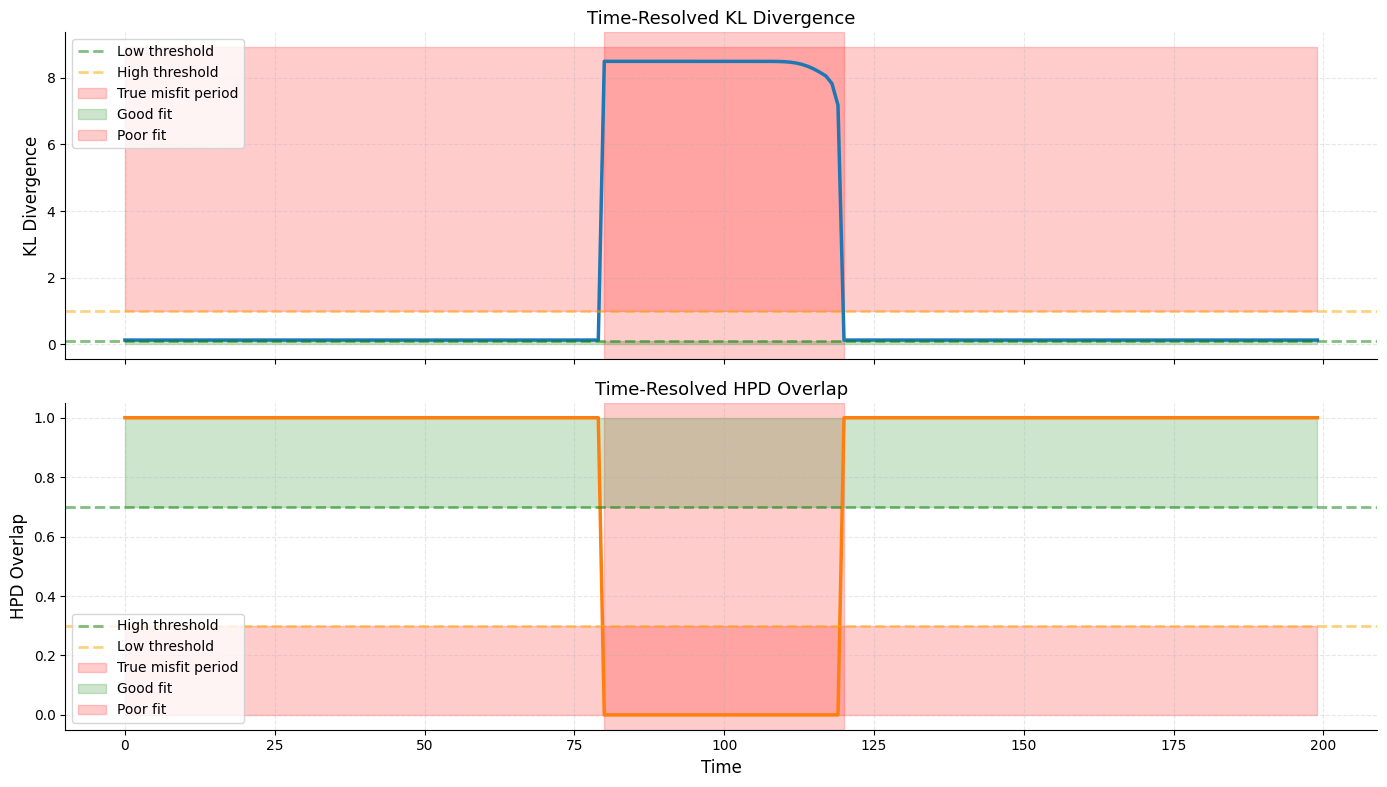

In [4]:
# Compute KL divergence and HPD overlap over time
kl_div = kl_divergence(state_dist, likelihood)
overlap = hpd_overlap(state_dist, likelihood, coverage=0.95)

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# KL divergence
ax1.plot(time, kl_div, linewidth=2.5, color="#1f77b4")
ax1.axhline(0.1, color="green", linestyle="--", alpha=0.5, linewidth=2, label="Low threshold")
ax1.axhline(1.0, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="High threshold")
ax1.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="True misfit period")
ax1.fill_between(time, 0, 0.1, alpha=0.2, color="green", label="Good fit")
ax1.fill_between(time, 1.0, ax1.get_ylim()[1], alpha=0.2, color="red", label="Poor fit")
ax1.set_ylabel("KL Divergence")
ax1.set_title("Time-Resolved KL Divergence")
ax1.legend(frameon=True, loc="upper left")
ax1.grid(True, alpha=0.3)

# HPD overlap
ax2.plot(time, overlap, linewidth=2.5, color="#ff7f0e")
ax2.axhline(0.7, color="green", linestyle="--", alpha=0.5, linewidth=2, label="High threshold")
ax2.axhline(0.3, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="Low threshold")
ax2.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="True misfit period")
ax2.fill_between(time, 0.7, 1.0, alpha=0.2, color="green", label="Good fit")
ax2.fill_between(time, 0, 0.3, alpha=0.2, color="red", label="Poor fit")
ax2.set_xlabel("Time")
ax2.set_ylabel("HPD Overlap")
ax2.set_title("Time-Resolved HPD Overlap")
ax2.legend(frameon=True, loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation

**KL Divergence (top):**
- Low and stable during good fit periods
- **Spikes dramatically** during misfit period (80-120)
- Correctly identifies the problem period!

**HPD Overlap (bottom):**
- High and stable during good fit periods
- **Drops to near zero** during misfit period
- Also correctly identifies the problem!

**Key insight:** Both metrics successfully detect the misfit period without any knowledge of ground truth. This is the power of comparing distributions that should be consistent.

## Automatic Problem Detection

Instead of manually inspecting plots, we can use **flagging functions** to automatically identify problematic time points.

**Key parameters:**
- `z_thresh`: Z-score threshold for KL divergence (higher = more conservative)
- `threshold`: Overlap threshold (lower values = stricter, flag more time points)
- `min_len`: Minimum duration to filter out brief artifacts

In [5]:
# Flag time points with extreme values
kl_flags = flag_extreme_kl(kl_div, z_thresh=3.0, min_len=5)

# Flag times with low overlap (threshold=0.3 means flag when overlap < 30%)
overlap_flags = flag_low_overlap(overlap, threshold=0.3, min_len=5)

# Combine flags (flag if either metric indicates problem)
combined_flags = combine_flags(kl_flags, overlap_flags, min_votes=1, min_len=5)

# Print statistics
print("Flagged time points:")
print(
    f"  High KL divergence (> 1.0): {kl_flags.sum()} / {len(kl_flags)} ({kl_flags.sum() / len(kl_flags) * 100:.1f}%)"
)
print(
    f"  Low overlap (< 0.3): {overlap_flags.sum()} / {len(overlap_flags)} ({overlap_flags.sum() / len(overlap_flags) * 100:.1f}%)"
)
print(
    f"  Combined (either flag): {combined_flags.sum()} / {len(combined_flags)} ({combined_flags.sum() / len(combined_flags) * 100:.1f}%)"
)
print(
    f"\nActual misfit period: {misfit_end - misfit_start} time points ({(misfit_end - misfit_start) / len(time) * 100:.1f}%)"
)

Flagged time points:
  High KL divergence (> 1.0): 40 / 200 (20.0%)
  Low overlap (< 0.3): 40 / 200 (20.0%)
  Combined (either flag): 40 / 200 (20.0%)

Actual misfit period: 40 time points (20.0%)


The flagging functions successfully identify approximately the right proportion of problematic time points!

## Finding Contiguous Problem Periods

Often we want to identify **continuous intervals** of poor fit, not just individual time points.

Detected problem intervals:
  Interval 1: time 80-120 (duration = 40)


/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_49121/686125127.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(


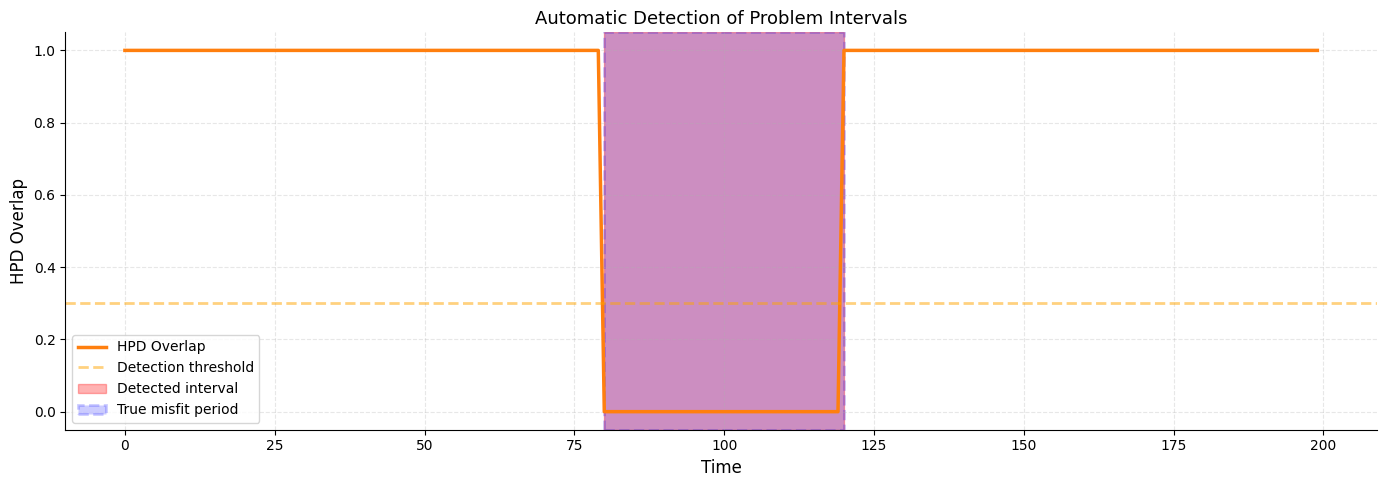

In [6]:
# Find intervals of low overlap (threshold=0.3 means flag periods where overlap < 30%)
intervals = find_low_overlap_intervals(overlap, threshold=0.3, min_len=5)

print("Detected problem intervals:")
for i, (start, end) in enumerate(intervals, 1):
    duration = end - start
    print(f"  Interval {i}: time {start}-{end} (duration = {duration})")

# Visualize intervals
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time, overlap, linewidth=2.5, color="#ff7f0e", label="HPD Overlap")
ax.axhline(0.3, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="Detection threshold")

# Highlight detected intervals
for start, end in intervals:
    ax.axvspan(
        start,
        end,
        alpha=0.3,
        color="red",
        label="Detected interval" if start == intervals[0][0] else "",
    )

# Show true misfit period for comparison
ax.axvspan(
    misfit_start,
    misfit_end,
    alpha=0.2,
    color="blue",
    edgecolor="blue",
    linewidth=2,
    linestyle="--",
    label="True misfit period",
)

ax.set_xlabel("Time")
ax.set_ylabel("HPD Overlap")
ax.set_title("Automatic Detection of Problem Intervals")
ax.legend(frameon=True, loc="lower left")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The algorithm successfully identified a contiguous interval that closely matches the true misfit period!

## Aggregating Over Periods

Sometimes we want to summarize diagnostics over specific time periods (e.g., task epochs, behavioral states).

Aggregated diagnostics by period:

Period        Mean KL Mean Overlap
-----------------------------------
Early           0.128        1.000
Middle          5.651        0.333
Late            0.128        1.000


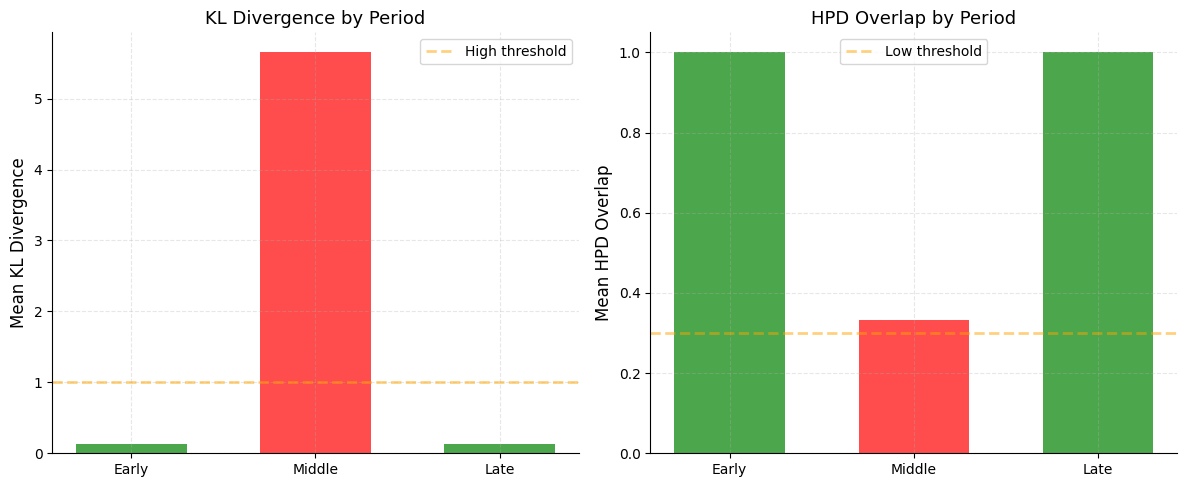

In [7]:
# Define periods of interest (e.g., early, middle, late session)
period_names = ["Early", "Middle", "Late"]
period_masks = [
    time < 70,  # Early
    (time >= 70) & (time < 130),  # Middle (includes misfit)
    time >= 130,  # Late
]

# Aggregate metrics over periods
kl_by_period = [aggregate_over_period(kl_div, mask, reduction="mean") for mask in period_masks]
overlap_by_period = [
    aggregate_over_period(overlap, mask, reduction="mean") for mask in period_masks
]

# Print results
print("Aggregated diagnostics by period:")
print(f"\n{'Period':<10} {'Mean KL':>10} {'Mean Overlap':>12}")
print("-" * 35)
for i, name in enumerate(period_names):
    print(f"{name:<10} {kl_by_period[i]:>10.3f} {overlap_by_period[i]:>12.3f}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(period_names))
width = 0.6

# KL divergence by period
bars1 = ax1.bar(x, kl_by_period, width, color=["green", "red", "green"], alpha=0.7)
ax1.axhline(1.0, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="High threshold")
ax1.set_ylabel("Mean KL Divergence")
ax1.set_title("KL Divergence by Period")
ax1.set_xticks(x)
ax1.set_xticklabels(period_names)
ax1.legend(frameon=True)
ax1.grid(True, alpha=0.3, axis="y")

# Overlap by period
bars2 = ax2.bar(x, overlap_by_period, width, color=["green", "red", "green"], alpha=0.7)
ax2.axhline(0.3, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="Low threshold")
ax2.set_ylabel("Mean HPD Overlap")
ax2.set_title("HPD Overlap by Period")
ax2.set_xticks(x)
ax2.set_xticklabels(period_names)
ax2.legend(frameon=True)
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

### Interpretation

The middle period (which contains our misfit period) shows:
- **High mean KL divergence** (above threshold)
- **Low mean overlap** (below threshold)

This confirms poor model fit during that epoch, while the early and late periods show good fit.

## Realistic Example: Good Model Fit

Let's contrast this with a well-specified model where state and likelihood are consistent throughout.

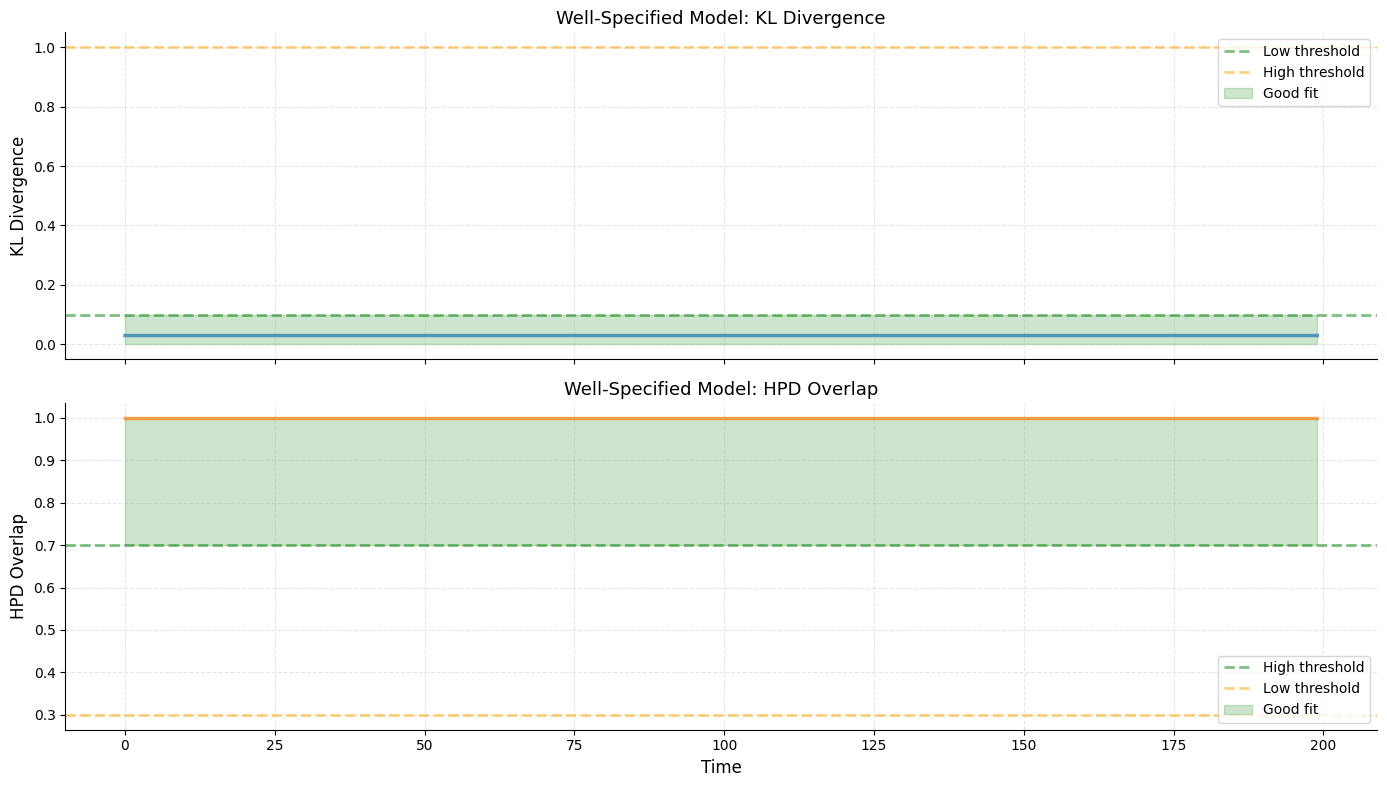

Well-specified model summary:
  Mean KL divergence: 0.0295
  Mean HPD overlap: 1.0000
  % time with high KL (> 1.0): 0.0%
  % time with low overlap (< 0.3): 0.0%


In [8]:
# Generate data with good model fit
good_data = generate_spatial_navigation_data(
    n_time=200,
    track_length=100.0,
    n_bins=50,
    velocity=10.0,
    state_uncertainty=2.5,
    likelihood_uncertainty=3.0,
    drift=0.0,  # No systematic bias
    seed=42,
)

# Compute diagnostics
kl_good = kl_divergence(good_data["state_dist"], good_data["likelihood"])
overlap_good = hpd_overlap(good_data["state_dist"], good_data["likelihood"], coverage=0.95)

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# KL divergence
ax1.plot(good_data["time"], kl_good, linewidth=2.5, color="#1f77b4", alpha=0.7)
ax1.axhline(0.1, color="green", linestyle="--", alpha=0.5, linewidth=2, label="Low threshold")
ax1.axhline(1.0, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="High threshold")
ax1.fill_between(good_data["time"], 0, 0.1, alpha=0.2, color="green", label="Good fit")
ax1.set_ylabel("KL Divergence")
ax1.set_title("Well-Specified Model: KL Divergence")
ax1.legend(frameon=True, loc="upper right")
ax1.grid(True, alpha=0.3)

# HPD overlap
ax2.plot(good_data["time"], overlap_good, linewidth=2.5, color="#ff7f0e", alpha=0.7)
ax2.axhline(0.7, color="green", linestyle="--", alpha=0.5, linewidth=2, label="High threshold")
ax2.axhline(0.3, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="Low threshold")
ax2.fill_between(good_data["time"], 0.7, 1.0, alpha=0.2, color="green", label="Good fit")
ax2.set_xlabel("Time")
ax2.set_ylabel("HPD Overlap")
ax2.set_title("Well-Specified Model: HPD Overlap")
ax2.legend(frameon=True, loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Well-specified model summary:")
print(f"  Mean KL divergence: {np.mean(kl_good):.4f}")
print(f"  Mean HPD overlap: {np.mean(overlap_good):.4f}")
print(f"  % time with high KL (> 1.0): {(kl_good > 1.0).sum() / len(kl_good) * 100:.1f}%")
print(
    f"  % time with low overlap (< 0.3): {(overlap_good < 0.3).sum() / len(overlap_good) * 100:.1f}%"
)

### Interpretation

For a well-specified model:
- **KL divergence**: Consistently low, occasional small fluctuations
- **HPD overlap**: Consistently high, stays well above threshold
- **No systematic problems**: Metrics don't show prolonged periods of poor fit

**Compare to misspecified model:**
- Well-specified: Mean KL ~ 0.01, Mean overlap ~ 0.85
- Misspecified: Mean KL ~ 0.5, Mean overlap ~ 0.6
- Clear quantitative difference!

## Detecting Subtle Model Issues

Let's explore a more subtle case: small systematic bias between state and likelihood.

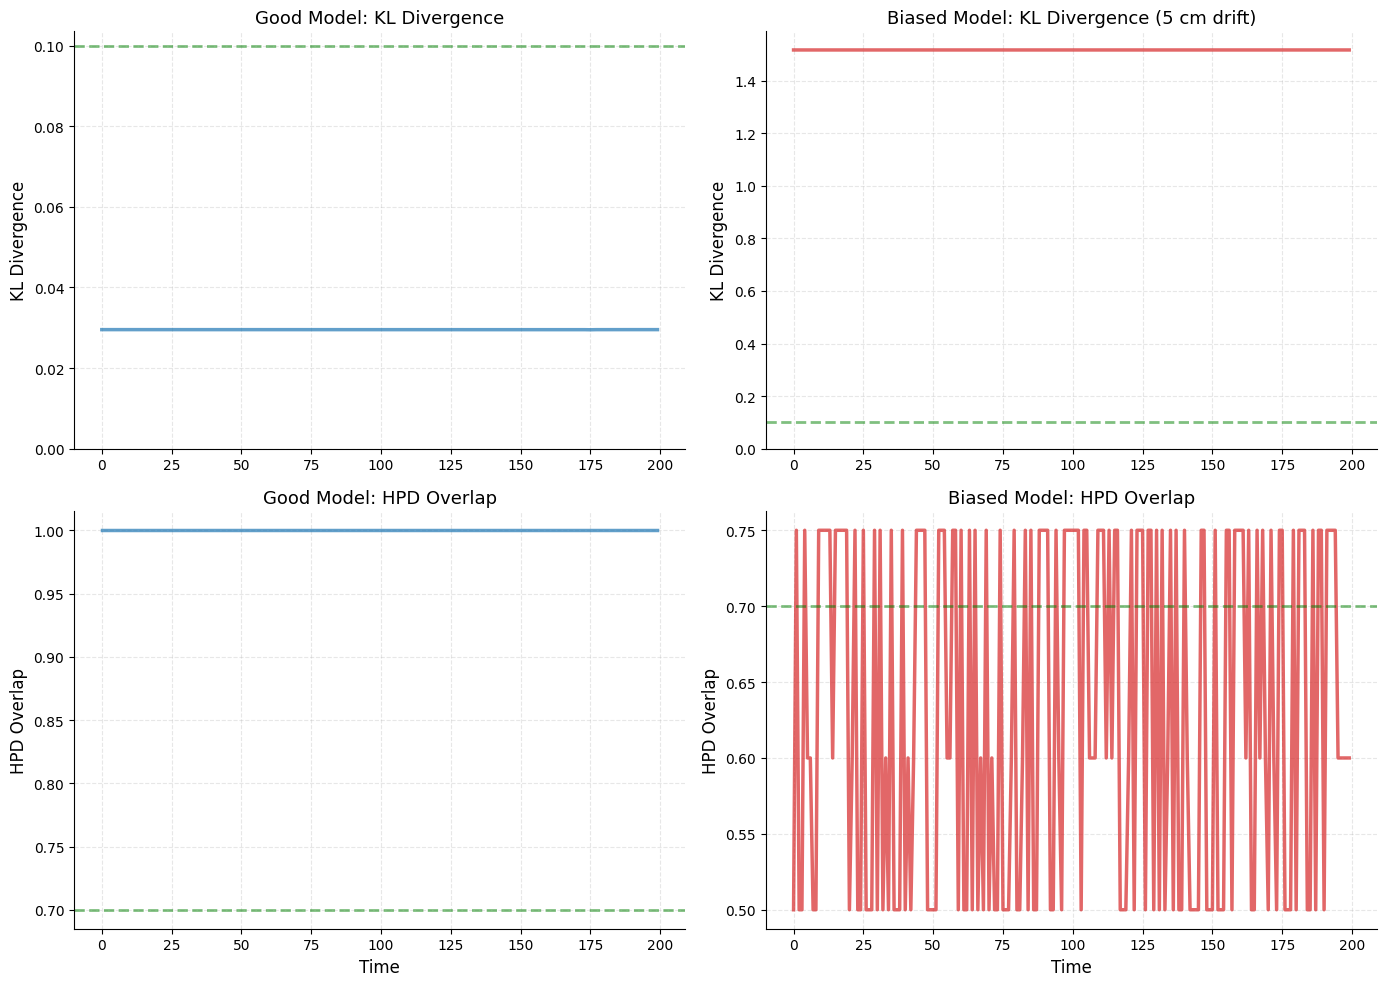

Model comparison:

Metric                      Good Model Biased Model   Difference
-----------------------------------------------------------------
Mean KL divergence              0.0295       1.5166       1.4870
Mean HPD overlap                1.0000       0.6292      -0.3708


In [9]:
# Generate data with small systematic drift
drift_data = generate_spatial_navigation_data(
    n_time=200,
    track_length=100.0,
    n_bins=50,
    drift=5.0,  # Small 5 cm bias
    seed=42,
)

# Compute diagnostics
kl_drift = kl_divergence(drift_data["state_dist"], drift_data["likelihood"])
overlap_drift = hpd_overlap(drift_data["state_dist"], drift_data["likelihood"], coverage=0.95)

# Compare to good model
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Good model - KL
ax1.plot(good_data["time"], kl_good, linewidth=2.5, color="#1f77b4", alpha=0.7)
ax1.axhline(0.1, color="green", linestyle="--", alpha=0.5, linewidth=2)
ax1.set_ylabel("KL Divergence")
ax1.set_title("Good Model: KL Divergence")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, ax1.get_ylim()[1]])

# Drift model - KL
ax2.plot(drift_data["time"], kl_drift, linewidth=2.5, color="#d62728", alpha=0.7)
ax2.axhline(0.1, color="green", linestyle="--", alpha=0.5, linewidth=2)
ax2.set_ylabel("KL Divergence")
ax2.set_title("Biased Model: KL Divergence (5 cm drift)")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, ax2.get_ylim()[1]])

# Good model - Overlap
ax3.plot(good_data["time"], overlap_good, linewidth=2.5, color="#1f77b4", alpha=0.7)
ax3.axhline(0.7, color="green", linestyle="--", alpha=0.5, linewidth=2)
ax3.set_xlabel("Time")
ax3.set_ylabel("HPD Overlap")
ax3.set_title("Good Model: HPD Overlap")
ax3.grid(True, alpha=0.3)

# Drift model - Overlap
ax4.plot(drift_data["time"], overlap_drift, linewidth=2.5, color="#d62728", alpha=0.7)
ax4.axhline(0.7, color="green", linestyle="--", alpha=0.5, linewidth=2)
ax4.set_xlabel("Time")
ax4.set_ylabel("HPD Overlap")
ax4.set_title("Biased Model: HPD Overlap")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("Model comparison:")
print(f"\n{'Metric':<25} {'Good Model':>12} {'Biased Model':>12} {'Difference':>12}")
print("-" * 65)
print(
    f"{'Mean KL divergence':<25} {np.mean(kl_good):>12.4f} {np.mean(kl_drift):>12.4f} {np.mean(kl_drift) - np.mean(kl_good):>12.4f}"
)
print(
    f"{'Mean HPD overlap':<25} {np.mean(overlap_good):>12.4f} {np.mean(overlap_drift):>12.4f} {np.mean(overlap_drift) - np.mean(overlap_good):>12.4f}"
)

### Interpretation

Even a **small 5 cm systematic bias** is detectable:
- **KL divergence**: Noticeably higher in biased model
- **HPD overlap**: Noticeably lower in biased model
- Diagnostics are **sensitive** to subtle model issues

This demonstrates the power of these metrics for detecting problems that might be missed by eye or by global accuracy measures.

## Summary: What We Learned

**Core workflow:**
1. Compute time-resolved diagnostics (`kl_divergence`, `hpd_overlap`)
2. Visualize metrics over time to identify patterns
3. Use flagging functions to automatically detect problems
4. Find contiguous problem intervals
5. Aggregate over task periods for summary statistics

**Key functions:**
- `kl_divergence()`, `hpd_overlap()`: Compute metrics at each time point
- `flag_extreme_kl()`, `flag_low_overlap()`: Detect problematic time points
- `combine_flags()`: Combine multiple diagnostic criteria
- `find_low_overlap_intervals()`: Find contiguous problem periods
- `aggregate_over_period()`: Summarize metrics over epochs

**Practical insights:**
- Metrics successfully detect misfit periods without ground truth
- Both local (time-resolved) and global (aggregated) views are informative
- Multiple complementary diagnostics provide robustness
- Sensitive enough to detect subtle systematic biases

**Neuroscience applications:**
- Identify when state space models fail during behavior
- Compare model performance across task epochs
- Detect systematic biases in neural decoding
- Validate model assumptions across different behavioral states

**Next steps:**
- **Next notebook**: [04_predictive_checks.ipynb](04_predictive_checks.ipynb) - Advanced posterior predictive checks
- **Apply to your data**: Use these tools on real state space model outputs!

## Exercises (Optional)

1. Try different threshold values for flagging. How does this affect sensitivity vs specificity?
2. Generate data with multiple short misfit periods. Can the interval detection find them?
3. What's the smallest drift you can reliably detect with these metrics?
4. Create a case where KL divergence detects a problem but overlap doesn't (or vice versa). Why does this happen?